In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r "/content/drive/MyDrive/Colab Notebooks/sur/" /content

In [1]:
import sys
sys.path.append('./sur')

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import os

import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset
print(torch.__version__)

from src.dataset import ImageDataset
from src.config import Config

cfg = Config()

2.2.1+cu121
Mean: [0.51393522 0.39408562 0.4046115 ], Std: [0.21051145 0.21676759 0.20957546]


In [3]:
# Training dataset
train_dataset = ImageDataset(root_dir=cfg.DATA_DIR, train=True, transform=cfg.TRANSFORM_TRAIN)
# Testing/validation dataset
test_dataset = ImageDataset(root_dir=cfg.DATA_DIR, train=False, transform=cfg.TRANSFORM_TEST)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of training samples: 151
Number of testing samples: 70


In [4]:
from torch.utils.data import DataLoader

# no num_workers or some weird stuff
train_dataloader_display = DataLoader(train_dataset, batch_size=1, shuffle=True, pin_memory=True)
test_dataloader_display = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)

Feature batch shape: torch.Size([1, 3, 80, 80])
Labels batch shape: torch.Size([1])
Label: 0


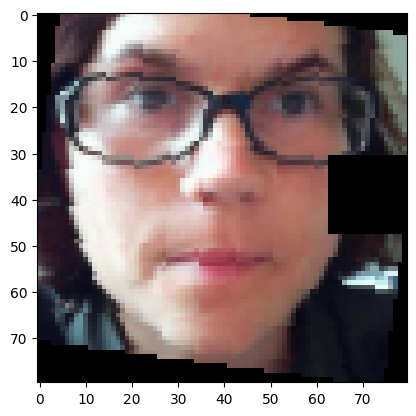

In [5]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader_display))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
print(f"Label: {label}")
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [6]:
# no num_workers or some weird stuff
train_dataloader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False, pin_memory=True)

In [7]:
from torch.optim import SGD, Adam
from src.models.resnet9 import ResNet9

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #- mx250 throwing bsod (:

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
else:
    print('Using CPU')

model = ResNet9(3, cfg.NUM_CLASSES).to(device)
optimizer_sgd = SGD(model.parameters(), lr=cfg.MAX_LR, momentum=cfg.MOMENTUM, weight_decay=cfg.WEIGHT_DECAY, nesterov=cfg.NESTEROV)

Tesla T4


In [11]:
from src.trainmodel import train

print(f"Training on {len(train_dataset)} samples and validating on {len(test_dataset)} samples")
history, best_model_w, best_epoch = train(model, train_dataloader, test_dataloader, cfg.EPOCHS, optimizer_sgd,
       device, cfg, grad_clip=cfg.GRAD_CLIP, verbose=True)

Training on 151 samples and validating on 70 samples
[Epoch: 01/569] - 0.58s | LR: 0.000012 | Train Loss: 0.0606 | Train Acc: 96.52 | Test Loss: 0.0385 | Test Acc: 98.57
[Epoch: 02/569] - 0.55s | LR: 0.000012 | Train Loss: 0.0270 | Train Acc: 99.37 | Test Loss: 0.0431 | Test Acc: 97.14
[Epoch: 03/569] - 0.56s | LR: 0.000012 | Train Loss: 0.0364 | Train Acc: 98.75 | Test Loss: 0.0416 | Test Acc: 97.14
[Epoch: 04/569] - 0.54s | LR: 0.000012 | Train Loss: 0.0288 | Train Acc: 98.57 | Test Loss: 0.0557 | Test Acc: 97.14
[Epoch: 05/569] - 0.54s | LR: 0.000012 | Train Loss: 0.0458 | Train Acc: 99.37 | Test Loss: 0.0670 | Test Acc: 95.71
[Epoch: 06/569] - 0.57s | LR: 0.000012 | Train Loss: 0.0384 | Train Acc: 98.12 | Test Loss: 0.0450 | Test Acc: 97.14
[Epoch: 07/569] - 0.53s | LR: 0.000012 | Train Loss: 0.0500 | Train Acc: 98.12 | Test Loss: 0.0403 | Test Acc: 98.57
[Epoch: 08/569] - 0.59s | LR: 0.000012 | Train Loss: 0.0335 | Train Acc: 100.00 | Test Loss: 0.0358 | Test Acc: 100.00
[Epoch: 0

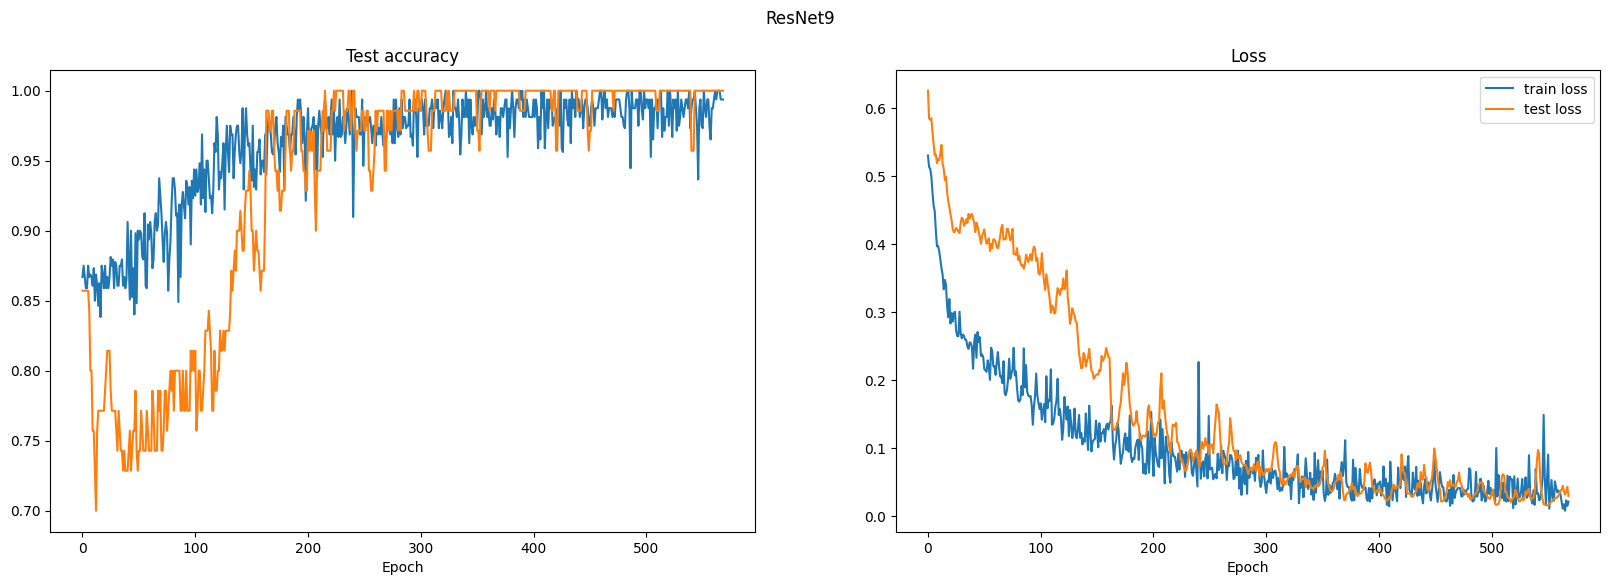

In [85]:
from src.utils import plot_graphs

plot_graphs(history, "ResNet9")

In [29]:
# save model
from src.trainmodel import save_model
gdrive_path = '/content/drive/MyDrive/Colab Notebooks/sur/checkpoints/'

model.load_state_dict(best_model_w)
save_model(model, optimizer_sgd, cfg.EPOCHS, gdrive_path+f"img_model-ResNet9-{best_epoch}e", history)

In [70]:
from src.trainmodel import load_model
model_state_dict, optimizer, start_epoch, history = load_model("checkpoints/img_model-ResNet9-1173e.model")

In [71]:
# get predictions from test_dataloader_display
from src.models.resnet9 import ResNet9
from src.trainmodel import evaluate

device = torch.device('cpu')

model = ResNet9(3, cfg.NUM_CLASSES)
model.load_state_dict(model_state_dict)

criterion = torch.nn.CrossEntropyLoss()
model.to(device)
criterion.to(device)


CrossEntropyLoss()

In [72]:
test_loss, test_acc = evaluate(model, test_dataloader, device, criterion,)
train_loss, train_acc = evaluate(model, train_dataloader, device, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

# 4 test images
test_features, test_labels = next(iter(test_dataloader_display))
print(f"Feature batch shape: {test_features.size()}")
# get predictions
model.eval()
with torch.no_grad():
    test_features = test_features.to(device)
    test_labels = test_labels.to(device)
    test_outputs = model(test_features)

print(test_outputs)


Test Loss: 0.0191, Test Acc: 1.0000
Train Loss: 0.0035, Train Acc: 1.0000
Feature batch shape: torch.Size([5, 3, 80, 80])
tensor([[ 5.3996, -3.8938],
        [-1.1936,  2.4771],
        [ 5.0442, -3.5767],
        [ 5.0722, -3.7207],
        [ 2.3247, -1.1591]])
